# Benzie Conservation District - Volunteer Data Science Project - Data Processing
## Mees Franssen
Jupyter notebook for all the preprocessing done on the data for plotting done in mapping.ipynb

In [447]:
# importing relevant packages
import os
import re
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from rapidfuzz import process, fuzz

## GIS Data of Lakes from the State of Michigan
To complete this project, we are going to need some GIS data about the locations of inland lakes and great lake jurisdictions. This was gathered from the State of Michigans opendata service, and was last updated in 2024. Considering we are only applying this data for their geometries, this is appropriate (if we are including environmental data, we might want an updated source). The three geojson files used are: County.geojson, great_lakes.geojson, and inland_lakes_and_rivers.geojson. 

In addition to the state GIS data, there is obviously also the boater data collected by the BCD. In excel I have done some very rudimentary preprocessing (combining all data into one sheet, as opposed to many different csv). All other modifications are done in this notebook.

59939 5670


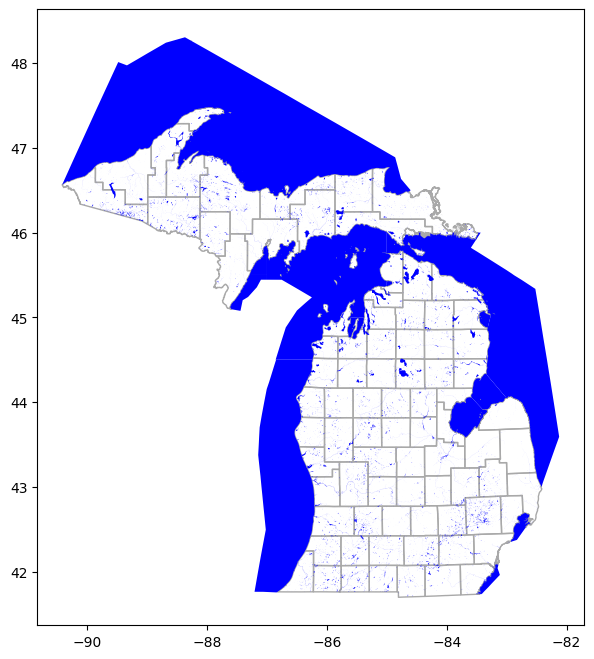

In [448]:
# Getting the data
counties_filepath = '/Data/County.geojson'
counties = gpd.read_file(os.getcwd() + counties_filepath)
counties = counties[['Name', 'geometry']] # we only need counties for the outlines of county lines, rest is irrelevant

inland_water_filepath = '/Data/inland_lakes_and_rivers.geojson'
inland_water = gpd.read_file(os.getcwd() + inland_water_filepath)
inland_water = inland_water[['NAME', 'geometry']] # we only want this data for the lake shapes, rest is interesting but not relevant to what we need

great_lakes_filepath = '/Data/great_lakes.geojson'
great_lakes = gpd.read_file(os.getcwd() + great_lakes_filepath)
great_lakes = great_lakes.rename(columns={'AssessmentUnitName':'NAME'})
great_lakes = great_lakes[['NAME', 'geometry']] # same as inland water

boater_filepath = '/Data/dataset_1 - Sheet1.csv'
boater_data = pd.read_csv(os.getcwd() + boater_filepath)
boater_data = boater_data.rename(columns={'Event Location':'NAME'}) 

lakes = pd.concat([inland_water, great_lakes])

ax = counties.plot(figsize=(8,8), color='none', edgecolor='darkgray')
lakes.plot(color='blue', ax=ax)

print(len(lakes['NAME']), len(lakes['NAME'].unique()))

There are many lakes in Michigan, inland_water has nearly 60k rows, this needs to be narrowed down. We can filter this with a basic assumption:

$\textit{Lake names mentioned in the boater data are referring to the closest lake with that name}$

Intuitively, when a visitor says "I have been to Portage Lake", it is likely the Portage lake 30 miles from the sample area, and not 400 miles away. Doing rudimentary filtering narrows down the reference list of lakes to just under 6k.

This might be a suspicious reduction. Its because there are a very large number of lakes denoted "Unnamed Lake" or something to that degree, these are all dropped. The rest of the truncation is finding the unique lake names. 

5670 5669


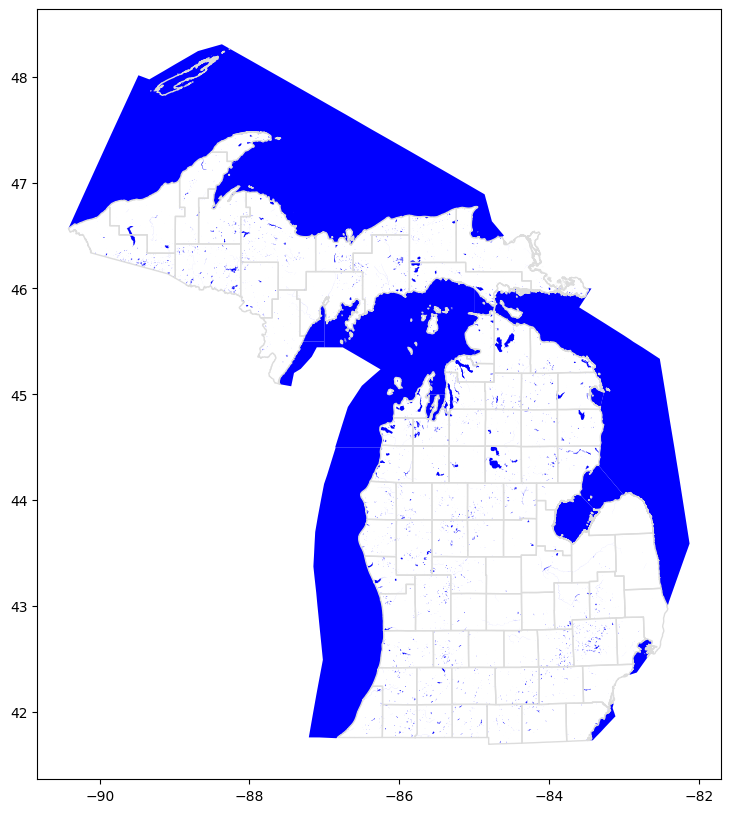

In [449]:
# Preprocessing our lakes reference list

lakes = lakes.to_crs(epsg=3174)  # change crs to be able to calculate distance

# Create a reference point (also reprojected in the same crs allowing for distance calculation)
reference_point = gpd.GeoSeries([Point(-85.94, 44.66)], crs='EPSG:4326').to_crs(epsg=3174).iloc[0] # this point is near "Long Lake", central to the study area

lakes['centroid'] = lakes.geometry.centroid # create a column called centroid, ie the middle of all the lakes
lakes['distance_to_ref'] = lakes['centroid'].distance(reference_point) # calcualte the distance of the middle of the lake to the reference point Long Lake
lakes = lakes.sort_values('distance_to_ref').drop_duplicates(subset='NAME', keep='first') # keep only the first, ie closest, lake

# Reproject back to original crs for plotting (I prefer seeing the degrees)
lakes = lakes.to_crs(epsg=4326)

# make the names of the lakes all upper case, easier 
lakes['NAME']= lakes['NAME'].str.upper()
boater_data['NAME'] = boater_data['NAME'].str.upper()
boater_data['Prior Visits'] = boater_data['Prior Visits'].str.upper()

ax = counties.plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=3)
lakes.plot(color='blue', ax=ax)

print(len(lakes['NAME']),len(lakes['NAME'].unique()))

## BCD Collected Boater Data
Looking at our collected boater data, we see it needs some significant preprocessing work before it is useable.

In [450]:
boater_data.head()

,NAME,Date,County,Launch Location,Township,City/Village,Description of Event,License Plates / Places People from,PWC,P,F,SP,SB,K,DB,WB,O,Prior Visits
0,PLATTE LAKE,02/06/2023,Benzie,Arborvitae Drive MI 49640,Lake,Honor,Boat Wash Event,"MI, OH",2,3.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,"PEARL, ERIE, HOUGHTON, LONG, LIME, CRYSTAL, DO..."
1,BIG GLEN LAKE,09/06/2023,Leelanau,W. Day Forest Rd,Glen Arbor,Empire,M-22 Challenge pre-race boat washing with Glen...,MI,0,0.0,0.0,0.0,0.0,88.0,0.0,0.0,0.0,NaN
2,LONG LAKE,09/06/2023,Benzie,Dam Rd,Benzonia,Benzonia,Betsie River Cleanup,MI,0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,NaN
3,LONG LAKE,10/06/2023,Grand Traverse,Crescent Shores,Long Lake,Traverse City,Boat Wash Event,MI,2,4.0,12.0,9.0,0.0,2.0,0.0,0.0,1.0,"GRAND TRAVERSE, LONG, GLEN, GREEN, EAST BAY, D..."
4,PLATTE LAKE,16/06/2023,Benzie,Big Platte Launch DNR,Lake,Honor,Boat Wash Event,MI,0,0.0,3.0,2.0,0.0,3.0,0.0,0.0,0.0,"LAKE ANN (EARLIER TODAY), CRYSTAL (2 WEEKS), N..."


In [451]:
# lets isolate only the relevant columns for this analysis (name of the sampled lake, and the prior lakes the person has visited)
relevant_columns = ['NAME', 'Prior Visits']
boater_data = boater_data[relevant_columns]

boater_data.head()

,NAME,Prior Visits
0,PLATTE LAKE,"PEARL, ERIE, HOUGHTON, LONG, LIME, CRYSTAL, DO..."
1,BIG GLEN LAKE,NaN
2,LONG LAKE,NaN
3,LONG LAKE,"GRAND TRAVERSE, LONG, GLEN, GREEN, EAST BAY, D..."
4,PLATTE LAKE,"LAKE ANN (EARLIER TODAY), CRYSTAL (2 WEEKS), N..."


Now our reference list for lakes is ready, we can go ahead and start preprocessing the boater data collected by the BCD. Naming conventions in this data is inconsistant, and is hindered by typos and inconsistant recording methodology, so some caution is needed to do this correctly. We'll use rapid fuzz to connect the names mentioned in the boater data to the names mentioned in the reference list. Even then, we need to complete a whole lot of preprocessing before we can even do this. 

Some data points will have a date associated, say "Portage Lake (2 days ago)", but this is rare, therefore this temporal dimension has to be dropped (most points don't have it).

In [452]:
def clean_text(text):
    return str(text).strip().upper() if pd.notna(text) else ""

def get_best_match(name, reference_list, threshold=80):
    match = process.extractOne(name, reference_list, scorer=fuzz.token_sort_ratio)
    return match[0] if match and match[1] >= threshold else name

def fix_name(name, reference_list, threshold=75):
    name = clean_text(name)
    # Manual corrections, there are many consistent weird typos, it was easier to this than engineer one specific cure all
    if 'GT' in name or 'TRAVERSE' in name or 'EAST BAY' in name or 'WEST BAY' in name: # traverse of GT are common names for the Grand Traverse Bay
        return 'GRAND TRAVERSE BAY (LAKE MICHIGAN)'
    if 'GLEN' in name: # the reference list does not distinguish little glen from big glen, its just Glen Lake, all one body
        return 'GLEN LAKE'
    if 'POCTOGE' in name: # recurring typo of portage, validated with BCD that it should be portage
        return 'PORTAGE LAKE'
    if 'BETSIE' in name:
        return 'BETSIE LAKE'
    if 'LEELANAU' in name: # similarly, the reference list does not distinguish north vs south leelanau
        return 'LAKE LEELANAU'
    if 'SUTTON' in name: # sutton is a popular marina on lake MI
        return 'LAKE MICHIGAN NORTH OF FRANKFORT (MICHIGAN JURISDICTION)'
    if 'SAGINAW' in name: # popular marina on lake Huron
        return 'LAKE HURON (MICHIGAN JURISDICTION)'
    if 'HURON' in name or 'CANADA' in name or 'ONTARIO' in name: # huron and canada visitors in one
        return 'LAKE HURON (MICHIGAN JURISDICTION)'
    if 'BIG' in name and 'PLATTE' in name: # big platte lake is called platte lake in the reference 
        return 'PLATTE LAKE'
    if 'LAKE' not in name and 'RIVER' not in name:
        name += ' LAKE'
    if 'PLATTE' in name and 'RIVER' in name: # no need to distinguish between upper and lower platte river
        return 'PLATTE RIVER'
    if 'FRANKFORT' in name: # the marina of frankfort is in betsie lake, sometimes people give the place rather than the lake
        return 'BETSIE LAKE'
    if 'GRAND RAPIDS' in name:
        return 'REEDS LAKE'
    if 'MANISTEE' in name and 'RIVER' not in name:
        return 'MANISTEE LAKE'
    if 'MICHIGAN' in name: # if in lake michigan, assume local lake michigan area
        return 'LAKE MICHIGAN NORTH OF FRANKFORT (MICHIGAN JURISDICTION)'
    if 'CHARLEVOIX' in name:
        return 'LAKE CHARLEVOIX'
    if 'ELK LAKE' in name:
        return 'ELK RIVER'
    if 'BEAVER ISLAND' in name:
        return 'LAKE MICHIGAN NORTH OF FRANKFORT (MICHIGAN JURISDICTION)'
    if name=='CRYSTAL LAKE ONLY' or name=='BENZIE LAKE' or name=='CRYSTAL RIVER': # crystal lake is benzie lake (rather, benzie lake doesnt exist, they mean the lake in Benzie: crystal lake)
        return 'CRYSTAL LAKE'
    return get_best_match(name, reference_list, threshold)

def fix_name_list(names, reference_list, threshold=85):
    return [fix_name(name, reference_list, threshold) for name in names]

def clean_prior_visits(text):
    if pd.isna(text) or 'would not say' in str(text).lower():
        return []
    # Remove parentheses and dates
    text = re.sub(r'\([^)]*\)', '', str(text))
    text = re.sub(r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', '', text)
    text = re.sub(r'\b\d{4}-\d{2}-\d{2}\b', '', text)
    text = text.replace(';', ',')  # unify delimiters
    text = str(text).split('-')[0] # very annoying, some data has "LAKE - LOCATION" format, remove anything past the dash
    text = text.replace('/', ',') # sometimes a slash was used as a delimiter
    text = text.replace('LK.', 'LAKE')
    # Split and clean each name
    lake_names = [clean_text(lake) for lake in text.split(',')]
    return [lake for lake in lake_names if lake]  # drop empty strings

# Load reference lake names
reference_names = lakes['NAME'].dropna().str.upper().tolist()

# Before cleaning
print('BEFORE CLEANING:', boater_data['Prior Visits'].iloc[39])

# Clean columns
boater_data['NAME'] = boater_data['NAME'].apply(lambda n: fix_name(n, reference_names))
boater_data['Prior Visits'] = (
    boater_data['Prior Visits']
    .fillna('')
    .astype(str)
    .apply(clean_prior_visits)
    .apply(lambda lst: fix_name_list(lst, reference_names))
)

# After cleaning
print('AFTER CLEANING:', boater_data['Prior Visits'].iloc[39])
print('Unique Sampled locations:\n', len(boater_data['NAME'].unique()))
print('Unique prior visits:\n', len(boater_data['Prior Visits'].explode().unique()))

BEFORE CLEANING: SILVER LAKE (TODAY, 1 DAY, 2 DAYS, 1 WEEK, 3 WEEKS, 1 YEAR), CEDAR HEDGE LAKE (1 DAY), EAST GT BAY (1 DAY), WEST GT BAY (TODAY)
AFTER CLEANING: ['SILVER LAKE', 'CEDAR HEDGE LAKE', 'GRAND TRAVERSE BAY (LAKE MICHIGAN)', 'GRAND TRAVERSE BAY (LAKE MICHIGAN)']
Unique Sampled locations:
 17
Unique prior visits:
 128


After processing, 17 out of 17 sampled lakes had correct references in the GIS data and can be plotted correctly. While of all the 130 unique lakes in prior visits, 106 of them had exact matches that could be plotted. Taking a closer look at the none matches, it seems reasonable to say these are waterbodies either out of state or otherwise erronious (variations of "boater would not say" or "first time in water"). 82% of waterbodies in prior visits were matched correctly. This is considered satisfactory for continuing the analysis. 

At this stage, I am opting to drop the names of the lakes that are not matched correctly, having looked at the none matches, 24 of them were a variation of "first time in water" or "would not say". The remaining were different lakes I could not verify the location of. 

## Matching the geometries to the names
Now that the boater data lake names have been processed, we can sparce through the reference list of lakes to match the names with the geometries we need for plotting.

In [453]:
boater_data = boater_data.explode('Prior Visits').dropna()
boater_data

,NAME,Prior Visits
0,PLATTE LAKE,PEARL LAKE
0,PLATTE LAKE,LAKE ERIE
0,PLATTE LAKE,HOUGHTON LAKE
0,PLATTE LAKE,LONG LAKE
0,PLATTE LAKE,LIME LAKE
...,...,...
215,UPPER HERRING LAKE,FISH LAKE
216,UPPER HERRING LAKE,CRYSTAL LAKE
217,UPPER HERRING LAKE,CRYSTAL LAKE
218,UPPER HERRING LAKE,CRYSTAL LAKE


In [454]:
geometry_dict = lakes.set_index('NAME')['geometry'].to_dict()

boater_data = boater_data[boater_data['NAME'].isin(lakes.NAME)] # validated that any name not matched previously is either out of state of "first time in water"
boater_data = boater_data[boater_data['Prior Visits'].isin(lakes.NAME)]

# even after the preprocessing, some weird lake names continued, these are fixed here
boater_data = boater_data.replace('WEST BEAR LAKE', 'BEAR LAKE').replace('EAST BEAR LAKE', 'BEAR LAKE')
boater_data = boater_data.replace('CHARLEVOIX LAKE', 'LAKE CHARLEVOIX')
boater_data = boater_data.replace('MID LAKE', 'MUD LAKE')
boater_data = boater_data.replace('TRIPP LAKE', 'LAKE CHARLEVOIX')
boater_data = boater_data.replace('LIME LAKE', 'LAKE ANN')


boater_data['SampledGeometry'] = boater_data['NAME'].map(geometry_dict)
boater_data['VisitedGeometry'] = boater_data['Prior Visits'].map(geometry_dict)

boater_data

,NAME,Prior Visits,SampledGeometry,VisitedGeometry
0,PLATTE LAKE,PEARL LAKE,POLYGON ((-86.06539406522583 44.68178788691969...,POLYGON ((-85.90356533882527 44.76110405509598...
0,PLATTE LAKE,LAKE ERIE,POLYGON ((-86.06539406522583 44.68178788691969...,"POLYGON ((-83.40911839300973 41.8277435033062,..."
0,PLATTE LAKE,HOUGHTON LAKE,POLYGON ((-86.06539406522583 44.68178788691969...,POLYGON ((-84.69145444090637 44.30896432599718...
0,PLATTE LAKE,LONG LAKE,POLYGON ((-86.06539406522583 44.68178788691969...,POLYGON ((-85.76108758064252 44.70714457062429...
0,PLATTE LAKE,LAKE ANN,POLYGON ((-86.06539406522583 44.68178788691969...,POLYGON ((-85.84009791848092 44.70382409906194...
...,...,...,...,...
214,UPPER HERRING LAKE,GLOVERS LAKE,POLYGON ((-86.18804940383565 44.56074327271508...,POLYGON ((-86.07745580575036 44.48668832579757...
215,UPPER HERRING LAKE,FISH LAKE,POLYGON ((-86.18804940383565 44.56074327271508...,POLYGON ((-85.68611944713734 44.55006491140225...
216,UPPER HERRING LAKE,CRYSTAL LAKE,POLYGON ((-86.18804940383565 44.56074327271508...,POLYGON ((-86.14736272098915 44.63644970478361...
217,UPPER HERRING LAKE,CRYSTAL LAKE,POLYGON ((-86.18804940383565 44.56074327271508...,POLYGON ((-86.14736272098915 44.63644970478361...


<Axes: >

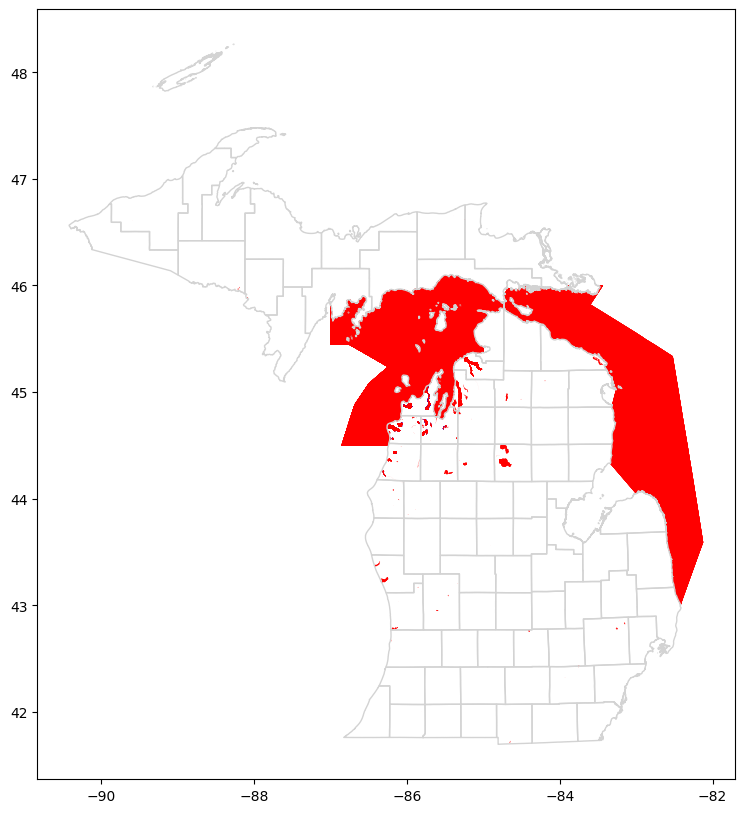

In [455]:
boater_data.to_csv(os.getcwd() + '/Data/cleaned_boater.csv')
boater_data = gpd.GeoDataFrame(boater_data, geometry='SampledGeometry', crs='EPSG:4326')

ax = counties.plot(figsize=(10,10), color='none', edgecolor='lightgrey', zorder=3)
boater_data.plot(color='blue', ax=ax)
boater_data.set_geometry('VisitedGeometry', crs='EPSG:4326').plot(color='red', ax=ax)

Plotting some first results just to make sure things went smoothly. There are no sampled lakes that have not also been visited (not surprising), and there are a great deal of visited lakes. This looks good to move forward with. 